# Fitting spectroscopy with Bagpipes

This notebook will take you through some of the considerations when performing full spectral fitting of spectroscopic data. All the information you need to complete the exercises should be available in the [Bagpipes documentation](https://bagpipes.readthedocs.io), or the [Jupyter notebook examples](https://github.com/ACCarnall/bagpipes/tree/master/examples) on the Bagpipes github repository. I'll be on hand during the session to discuss things with you, and provide advice if anything is confusing.

If you're new to Google Colab, this file is a Jupyter notebook running inside its own virtual machine on the Google servers, which I've pre-loaded with all the necessary software. This should allow you to get straight on with running the, code without having to worry about installation issues.

You can copy this document into your own Google drive to begin editing it. If you get into trouble, you can restart or factory reset the notebook/virtual machine under the Runtime menu at the top. You'll need to run the first cell to install the necessary software before getting started.

In [ ]:
# This first cell sets up the virtual machine with all the necessary software.
# There should be no need to edit this cell, just scroll down...

# Install Bagpipes and python dependencies
!pip install bagpipes

# Install MultiNest
!git clone https://www.github.com/johannesbuchner/multinest.git
!cd multinest/build && cmake .. && make && sudo make install

# Install PyMultiNest (with hacky solution to path issues)
!git clone https://www.github.com/ACCarnall/PyMultiNest
!cp -r PyMultiNest/pymultinest /usr/local/lib/python3.7/dist-packages/

# Install latex for plots
!sudo apt-get install texlive-latex-recommended
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
!wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip
!unzip type1cm.zip -d /tmp/type1cm
!cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
!sudo mkdir /usr/share/texmf/tex/latex/type1cm
!sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
!sudo texhash
!apt install cm-super

# Get the filter curves needed for the examples
!git clone https://github.com/ACCarnall/bagpipes
!mv bagpipes/examples/filters .
!rm -r bagpipes

# Adjust the output height to avoid a huge wall of installation text
from IPython import display
display.Javascript("google.colab.output.setIframeHeight('100px');")

     |████████████████████████████████| 206.0 MB 67 kB/s 
     |████████████████████████████████| 50 kB 7.6 MB/s 
     |████████████████████████████████| 9.5 MB 35.8 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


Cloning into 'multinest'...
remote: Enumerating objects: 549, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 549 (delta 65), reused 49 (delta 19), pack-reused 431
Receiving objects: 100% (549/549), 300.02 KiB | 12.00 MiB/s, done.
Resolving deltas: 100% (342/342), done.
-- The Fortran compiler identification is GNU 7.5.0
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working Fortran compiler: /usr/bin/f95
-- Check for working Fortran compiler: /usr/bin/f95  -- works
-- Detecting Fortran compiler ABI info
-- Detecting Fortran compiler ABI info - done
-- Checking whether /usr/bin/f95 supports Fortran 90
-- Checking whether /usr/bin/f95 supports Fortran 90 -- yes
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile feature

<IPython.core.display.Javascript object>

In [ ]:
# Import necessary python modules

import numpy as np
import bagpipes as pipes
import os

BAGPIPES: Generating IGM absorption table.


# Getting started - mock spectroscopic data

To start with we'll need to mock up some spectroscopic data to try to fit. For this notebook, I'll use the example of a massive quiescent galaxy at z=2.5, which quenched at about z=4. I'll create mock observations as if the galaxy were being observed with NIRSpec using the F100LP filter and G140M grating.

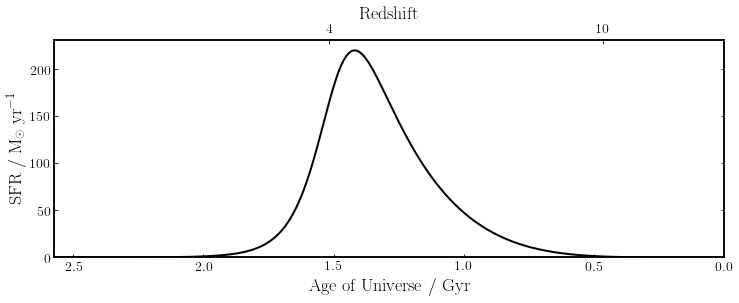

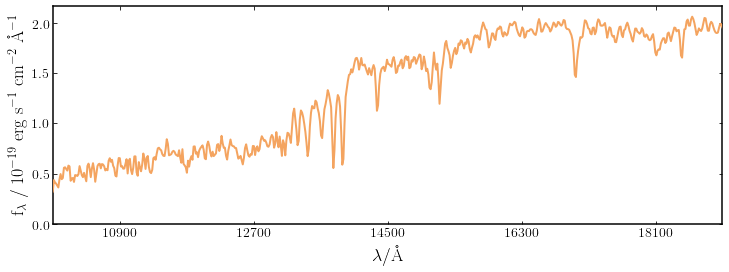

In [ ]:

dpl = {}
dpl["alpha"] = 20.
dpl["beta"] = 5.
dpl["tau"] = 1.5
dpl["massformed"] = 11.
dpl["metallicity"] = 1.

nebular = {}
nebular["logU"] = -3.

dust = {}
dust["type"] = "Calzetti"
dust["Av"] = 0.5

model_comp = {}
model_comp["dblplaw"] = dpl
model_comp["nebular"] = nebular
model_comp["dust"] = dust
model_comp["redshift"] = 2.5
model_comp["veldisp"] = 200.

model = pipes.model_galaxy(model_comp, spec_wavs=np.arange(10000., 19000., 15.))

fig = model.sfh.plot()
fig = model.plot()

I'm going to shortcut running this spectrum through the JWST ETC (though with an hour or two to spare this is a fun project!), and assume that with a couple of hours integration we can reach an average continuum SNR of 10 per FWHM. Let's use this assumption to add some noise to our mock spectrum to make a mock NIRSpec observation.

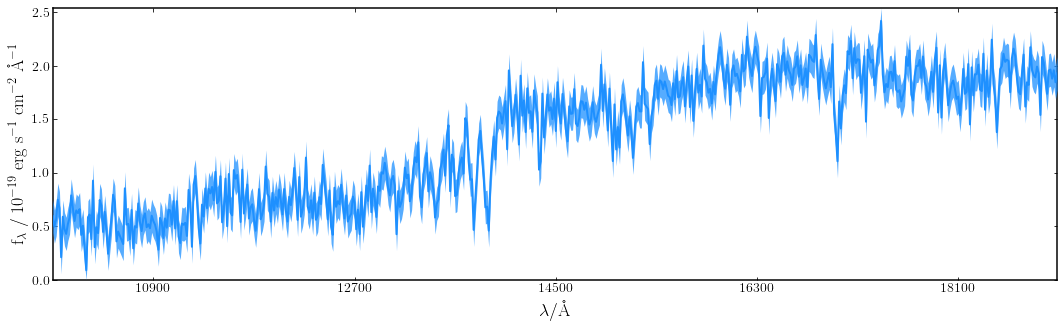

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
pipes.plotting.update_rcParams()

np.random.seed(0)  # Set the random seed for repeatable results

mock_spec = np.copy(model.spectrum)

fluxerr = np.median(mock_spec[:, 1])/10.  # Flux error is 1/10 of median flux

mock_spec[:, 1] += fluxerr*np.random.randn(mock_spec.shape[0])  # Add noise

mock_spec = np.c_[mock_spec, np.repeat(fluxerr, mock_spec.shape[0])]

fig = plt.figure(figsize=(18, 5))
ax = plt.subplot()

fig = pipes.plotting.add_spectrum(mock_spec, ax)

Let's now quickly verify we can recover our input parameters by fitting these data with our original model:

In [ ]:
def load_data(ID):
    return mock_spec

galaxy = pipes.galaxy("jwst_mock", load_data, photometry_exists=False)


dpl = {}
dpl["alpha"] = (0.01, 1000.)
dpl["alpha_prior"] = "log_10"
dpl["beta"] = (0.01, 1000.)
dpl["beta_prior"] = "log_10"
dpl["tau"] = (0., 15.)
dpl["massformed"] = (0., 13.)
dpl["metallicity"] = (0., 2.5)

nebular = {}
nebular["logU"] = -3.

dust = {}
dust["type"] = "Calzetti"
dust["Av"] = (0., 4.)

fit_info = {}
fit_info["dblplaw"] = dpl
fit_info["nebular"] = nebular
fit_info["dust"] = dust
fit_info["redshift"] = 2.5
fit_info["veldisp"] = (100., 500.)

fit = pipes.fit(galaxy, fit_info, run="test1")
fit.fit(sampler="nautilus")



Bagpipes: fitting object jwst_mock


Completed in 888.1 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dblplaw:alpha                 25.359    120.422    504.055
dblplaw:beta                   0.051      1.513    122.230
dblplaw:massformed            10.933     10.990     11.040
dblplaw:metallicity            0.845      1.059      1.392
dblplaw:tau                    1.323      1.654      1.871
dust:Av                        0.333      0.399      0.459
veldisp                      154.028    173.476    194.827




/usr/local/lib/python3.7/dist-packages/bagpipes/models/star_formation_history.py:270: RuntimeWarning: overflow encountered in power
  sfr[mask] = ((t/tau)**alpha + (t/tau)**-beta)**-1


/usr/local/lib/python3.7/dist-packages/bagpipes/models/star_formation_history.py:270: RuntimeWarning: overflow encountered in power
  sfr[mask] = ((t/tau)**alpha + (t/tau)**-beta)**-1


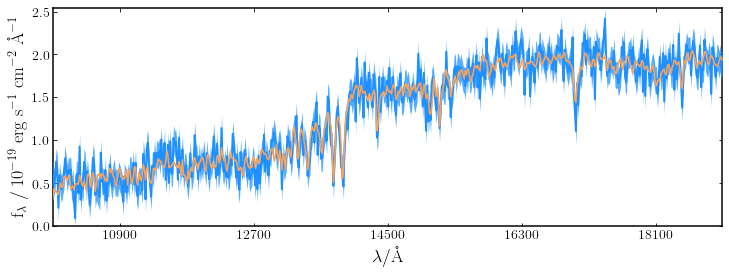

['dblplaw:alpha', 'dblplaw:beta', 'dblplaw:massformed', 'dblplaw:metallicity', 'dblplaw:tau', 'dust:Av', 'veldisp']
Truths: [20.0, 5.0, 11.0, 1.0, 1.5, 0.5, 200.0]


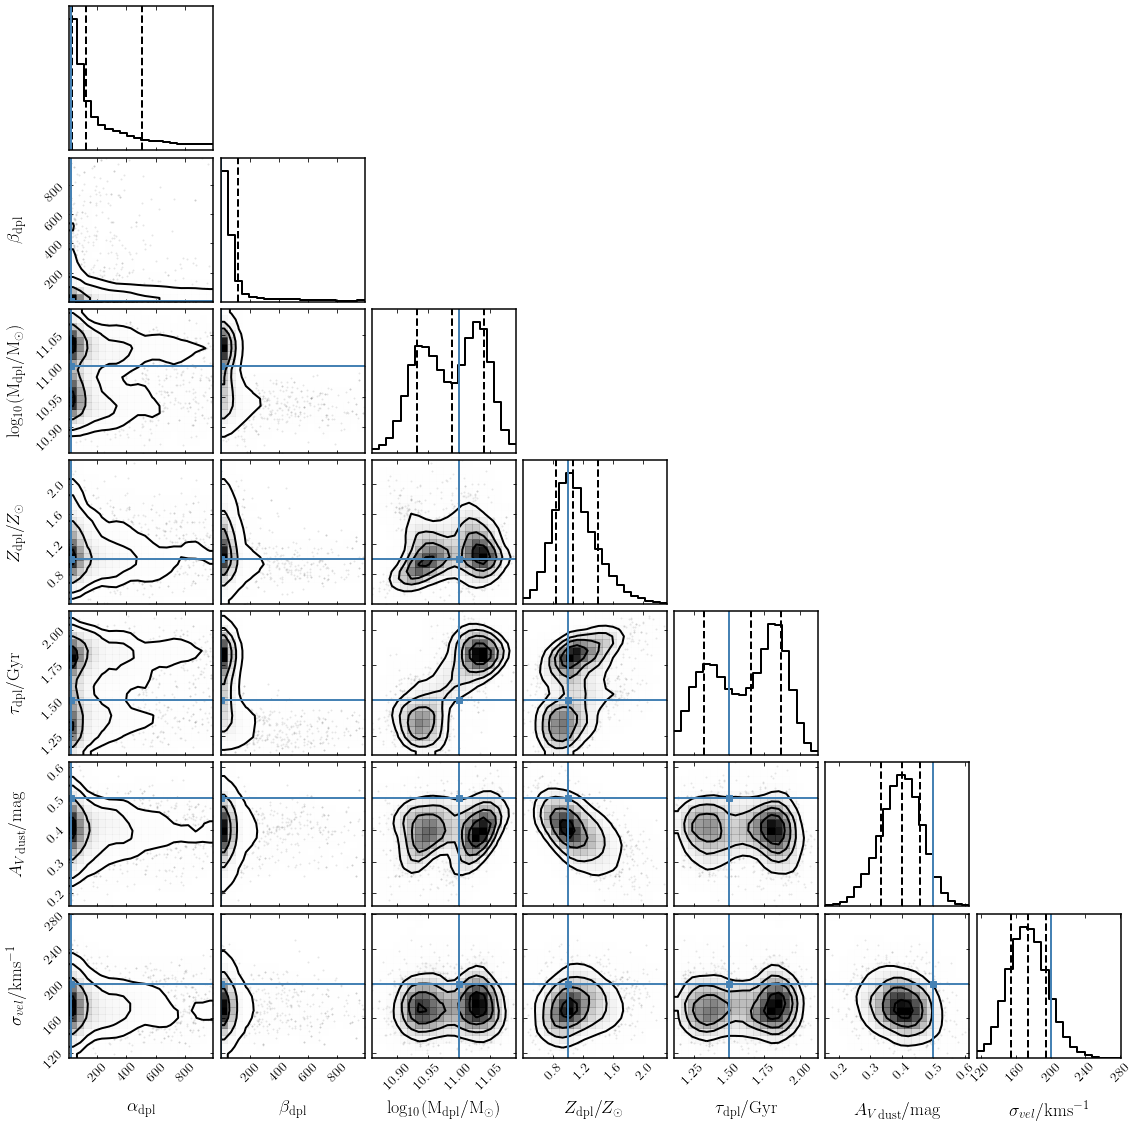

In [ ]:
fig = fit.plot_spectrum_posterior(show=True, save=False)

truths = [20., 5., 11., 1., 1.5, 0.5, 200.]

print(fit.fitted_model.params)
print("Truths:", truths)

labels = pipes.plotting.fix_param_names(fit.fitted_model.params)

import corner
fig = corner.corner(fit.posterior.samples2d, truths=truths, labels=labels,
                    quantiles=[0.16, 0.5, 0.84], smooth=1, smooth1d=1)

As you can see, running these fits is significantly more computationally intensive, which limits what I can ask you to do within the space of an hour long session.

I'm now going to perturb the mock spectrum to simulate the effects of poor spectrophotometric calibration and underestimated uncertainties. The numbers I'm using are based on personal experience with ground-based instrumentation - hopefully these issues will be much less important in real JWST data.

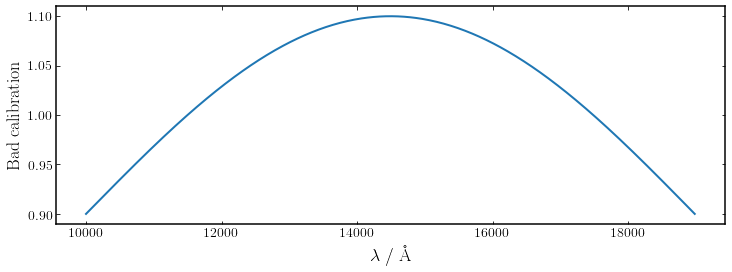

Before perturbation



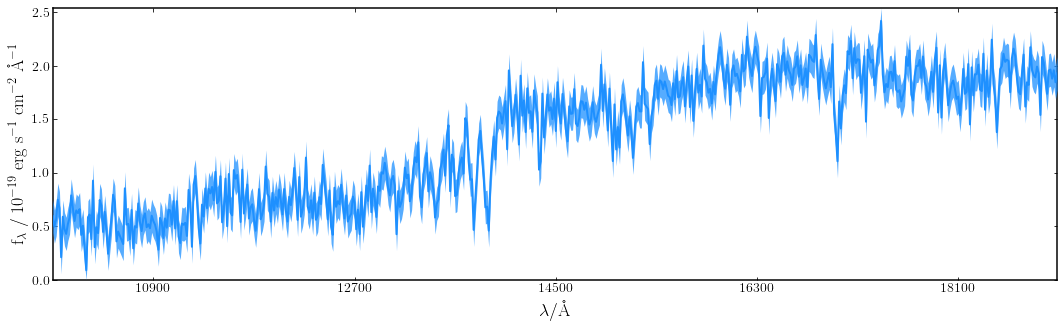

After perturbation



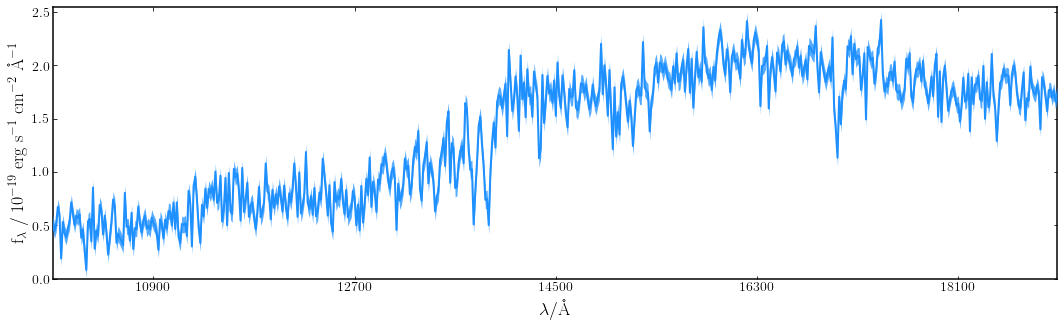

In [ ]:
# Generate a sinusoidal perturbation to the spectrophotometric calib
normalised_wavs = mock_spec[:, 0] - mock_spec[0, 0]
normalised_wavs /= normalised_wavs[-1]

bad_calib = 0.9 + 0.2*np.sin(np.pi*normalised_wavs)

# Plot the perturbation
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot()

ax.plot(mock_spec[:, 0], bad_calib)
ax.set_ylabel("$\mathrm{Bad\ calibration}$")
ax.set_xlabel("$\mathrm{\lambda\ /\ \AA}$")

plt.show()

# Plot the unperturbed spectrum
print("Before perturbation\n")
fig = plt.figure(figsize=(18, 5))
ax = plt.subplot()

fig = pipes.plotting.add_spectrum(mock_spec, ax)
plt.show()

# Create a perturbed version of the spectrum
mock_spec_perturbed = np.copy(mock_spec)

mock_spec_perturbed[:, 1:] *= np.expand_dims(bad_calib, -1)  # Mess up calib
mock_spec_perturbed[:, 2] /= 2.  # Underestimate errors

# Plot the perturbed spectrum
print("After perturbation\n")
fig = plt.figure(figsize=(18, 5))
ax = plt.subplot()

fig = pipes.plotting.add_spectrum(mock_spec_perturbed, ax)
plt.show()

def load_data_perturbed(ID):
    return mock_spec_perturbed


galaxy_perturbed = pipes.galaxy("jwst_mock_perturbed", load_data_perturbed,
                                photometry_exists=False)


At the end of the last code cell, I created a new galaxy object with this new, perturbed spectrum (galaxy_perturbed). Now, re-run the fit as above. Do you still get answers consistent with the input values? (Note: you can probably guess the answer here, and the fit is going to take some time, up to about half an hour, so if you like, just go and check out my model solution, then skip ahead to the next part.)


Bagpipes: fitting object jwst_mock_perturbed


Completed in 1372.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dblplaw:alpha                 70.862    192.697    574.296
dblplaw:beta                   3.567      7.478     18.172
dblplaw:massformed            10.806     10.816     10.831
dblplaw:metallicity            2.390      2.451      2.487
dblplaw:tau                    1.906      1.983      2.063
dust:Av                        0.274      0.305      0.336
veldisp                      169.693    180.179    192.139




/usr/local/lib/python3.7/dist-packages/bagpipes/models/star_formation_history.py:270: RuntimeWarning: overflow encountered in power
  sfr[mask] = ((t/tau)**alpha + (t/tau)**-beta)**-1


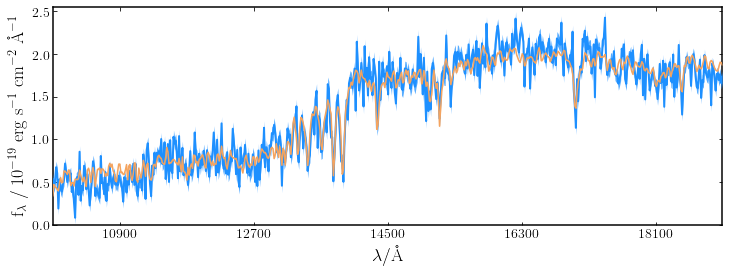

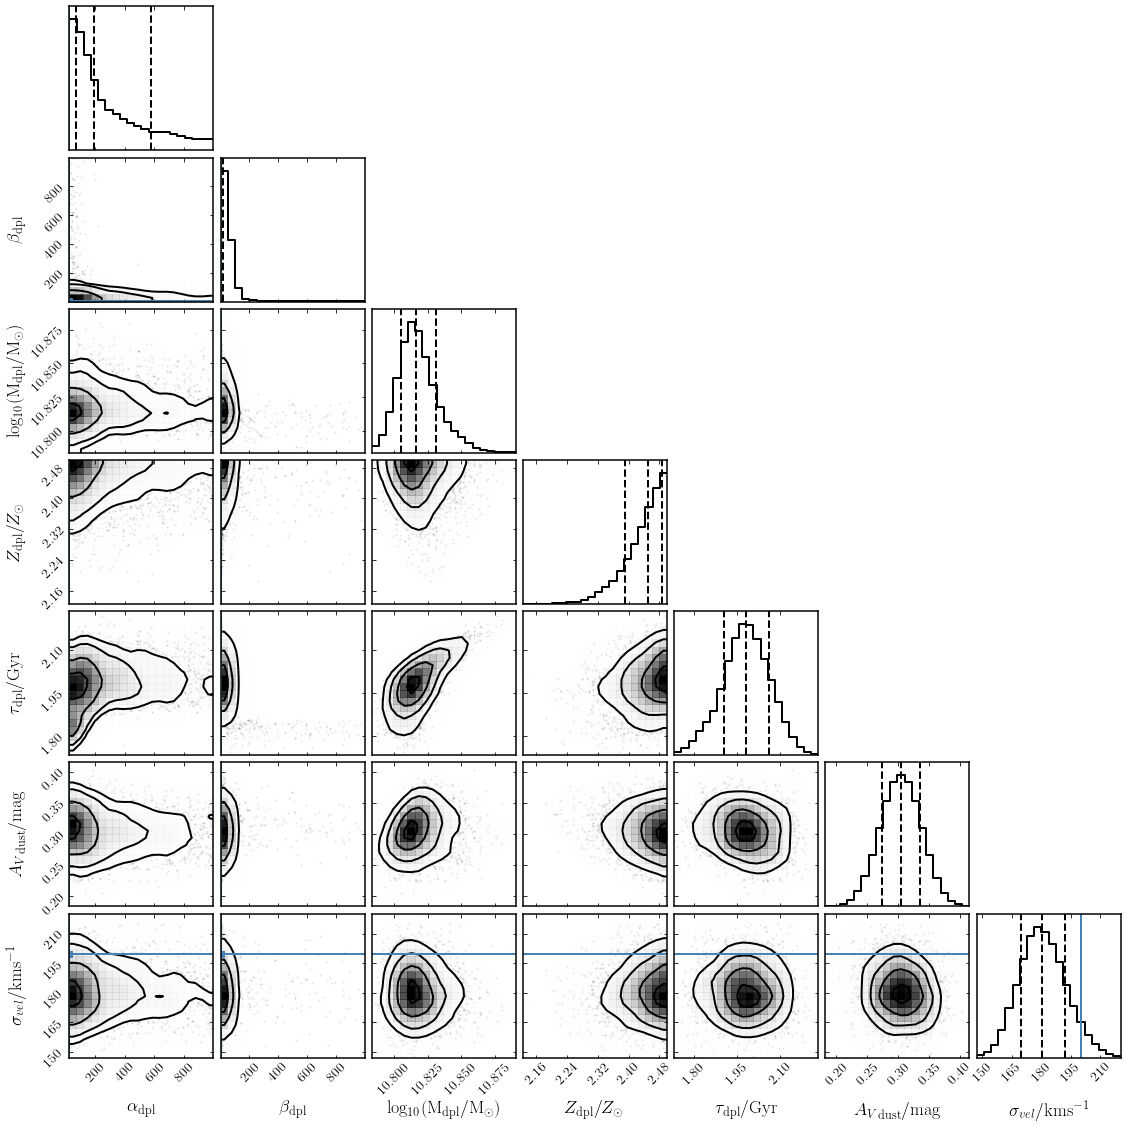

In [ ]:
# Your code here

# Run the fit
fit = pipes.fit(galaxy_perturbed, fit_info, run="test1")
fit.fit()

# Make the plots
fig = fit.plot_spectrum_posterior(show=True, save=False)

truths = [20., 5., 11., 1., 1.5, 0.5, 200.]

labels = pipes.plotting.fix_param_names(fit.fitted_model.params)

import corner
fig = corner.corner(fit.posterior.samples2d, truths=truths, labels=labels,
                    quantiles=[0.16, 0.5, 0.84], smooth=1, smooth1d=1)


Let's try to rectify this situation. Using the material presented in the [fifth GitHub Jupyter notebook example](https://github.com/ACCarnall/bagpipes/blob/master/examples/Example%205%20-%20Fitting%20spectroscopic%20data.ipynb), add a calibration component using the "polynomial_bayesian" method, and a noise component using the "white_scaled" method. Can you a.) obtain the correct physical parameters, and b.) recover the factor of two error underestimation and correct shape of the calibration perturbation?



In [ ]:
# Your code here

# Update the fit_info dict
from copy import deepcopy
new_fit_info = deepcopy(fit_info)

calib = {}
calib["type"] = "polynomial_bayesian"

calib["0"] = (0.5, 1.5)
calib["0_prior"] = "Gaussian"
calib["0_prior_mu"] = 1.0
calib["0_prior_sigma"] = 0.25

calib["1"] = (-0.5, 0.5)
calib["1_prior"] = "Gaussian"
calib["1_prior_mu"] = 0.
calib["1_prior_sigma"] = 0.25

calib["2"] = (-0.5, 0.5)
calib["2_prior"] = "Gaussian"
calib["2_prior_mu"] = 0.
calib["2_prior_sigma"] = 0.25

noise = {}
noise["type"] = "white_scaled"
noise["scaling"] = (1., 10.)
noise["scaling_prior"] = "log_10"

new_fit_info["noise"] = noise
new_fit_info["calib"] = calib


# Run the fit
fit = pipes.fit(galaxy_perturbed, new_fit_info, run="test2")
fit.fit()



Bagpipes: fitting object jwst_mock_perturbed


Completed in 1954.3 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
calib:0                        0.912      1.107      1.281
calib:1                       -0.118     -0.045      0.069
calib:2                        0.086      0.108      0.130
dblplaw:alpha                 28.417    109.828    436.467
dblplaw:beta                   0.053      0.787     32.755
dblplaw:massformed            10.827     10.957     11.134
dblplaw:metallicity            0.876      1.154      1.559
dblplaw:tau                    1.421      1.742      1.921
dust:Av                        0.094      0.270      0.557
noise:scaling                  1.957      2.007      2.061
veldisp                      155.694    173.633    195.195




/usr/local/lib/python3.7/dist-packages/bagpipes/models/star_formation_history.py:270: RuntimeWarning: overflow encountered in power
  sfr[mask] = ((t/tau)**alpha + (t/tau)**-beta)**-1


/usr/local/lib/python3.7/dist-packages/bagpipes/models/star_formation_history.py:270: RuntimeWarning: overflow encountered in power
  sfr[mask] = ((t/tau)**alpha + (t/tau)**-beta)**-1


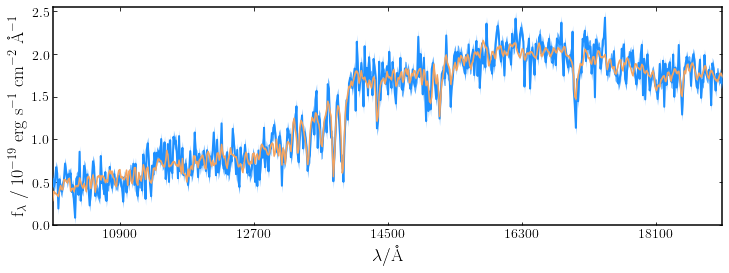

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


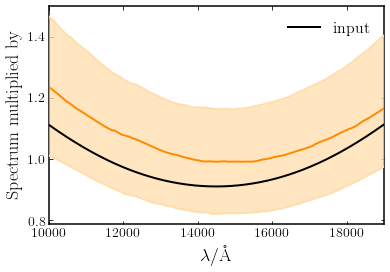

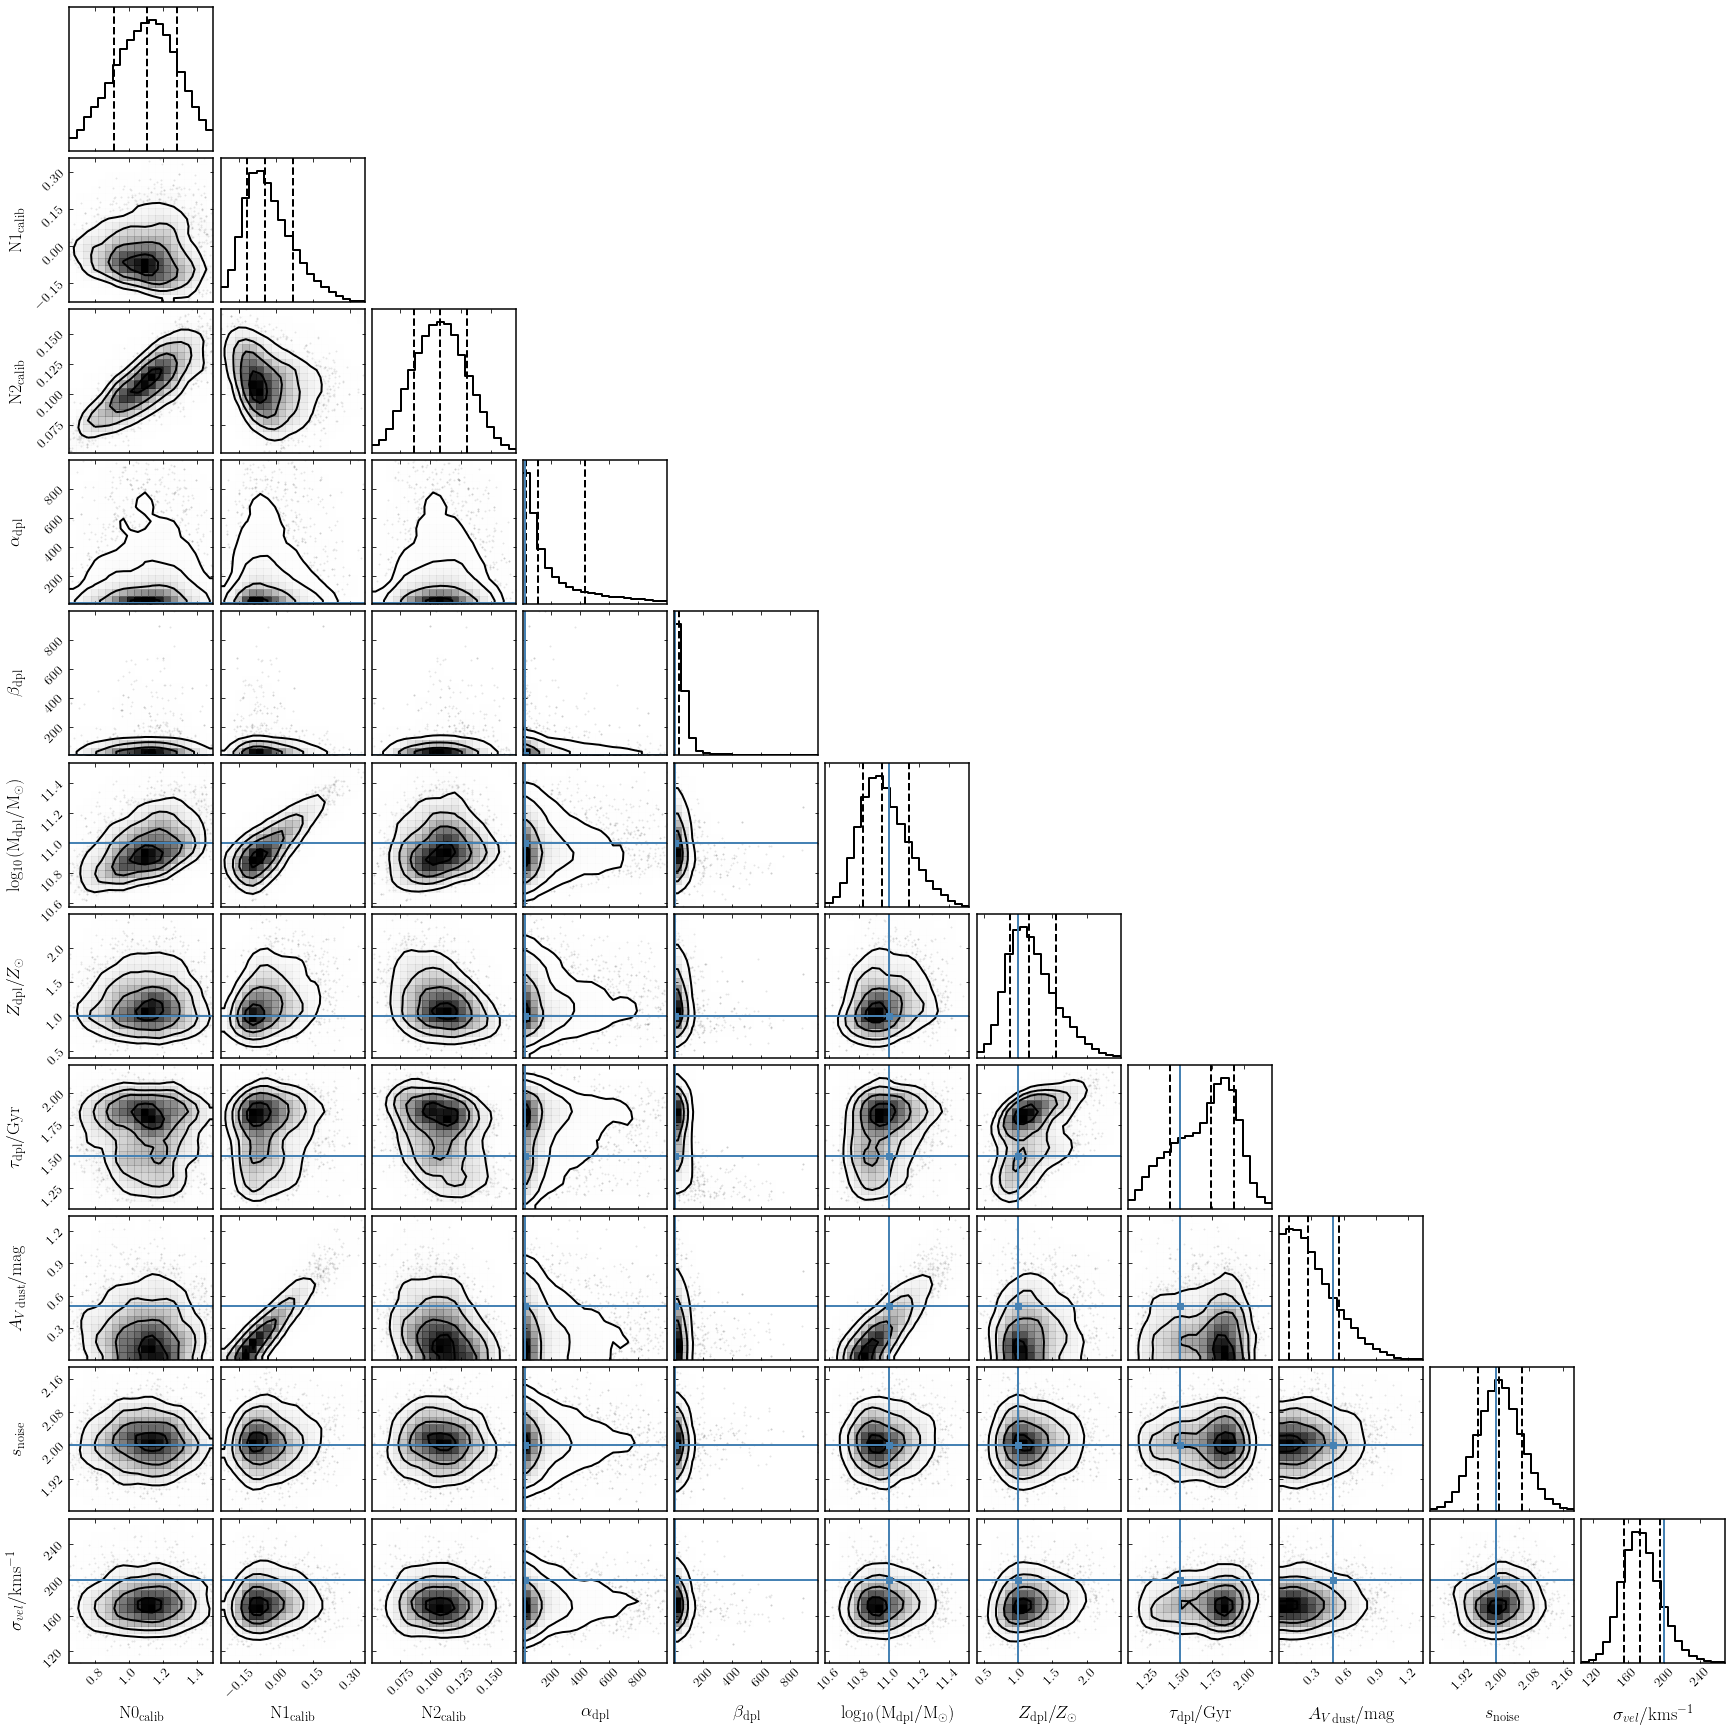

In [ ]:
# Make the plots
fig = fit.plot_spectrum_posterior(show=True, save=False)
fig, ax = fit.plot_calibration(save=False, show=False)

ax.plot(mock_spec[:, 0], 1./bad_calib, color="black", zorder=10,
        label="$\mathrm{input}$")

ax.legend(frameon=False, fontsize=16)

plt.show()

# We didn't input a polynomial, so I've set the truths to -999 for these params.
truths = [-999, -999, -999, 20., 5., 11., 1., 1.5, 0.5, 2, 200.]

labels = pipes.plotting.fix_param_names(fit.fitted_model.params)

import corner
fig = corner.corner(fit.posterior.samples2d, truths=truths, labels=labels,
                    quantiles=[0.16, 0.5, 0.84], smooth=1, smooth1d=1)


A few final thoughts:


*   If you're fitting spectroscopy (or just a complicated model to photometry really) I definitely recommend setting the n_live parameter of the fit.fit() method to 1000, rather than the default 400. This controls how fine-grained the sampling of parameter space by MultiNest is. The more live points, the more sure you can be that the parameter space has been well sampled. It's always a good idea to re-run at least one object a few times to check you're converging to the same answer each time.

*   Appropriate noise models/likelihood functions for spectroscopy depend a lot on the data you're working with. Bagpipes contains a few different options I've played with, but these aren't an exhaustive list of things that might be sensible in your scenario. The noise and calibration classes are deliberately over-engineered in the hope more options will be developed. The code is structured so you should be able to add/change things here without even reading the rest of the code (though an understanding of the fitted_model class, where the likelihood functions are, will be beneficial).

* I haven't at all gone into the Gaussian process noise model used in my 2019 paper, largely because it involves inverting a big matrix, which produces another big step up in runtime, which wasn't practical in Colab. You can find out more about this in the paper, or by talking to me.

* The zero order for the fitted polynomial isn't really constrained by anything other than the prior in this example. Usually, if you're fitting this you also have well calibrated photometry, which stays fixed and so keeps the polynomial in check. In this case, the zeroth order of the polynomial is basically fully degenerate with stellar mass, and the shape is being guided by the available stellar models.

